In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

#이후 런타임 다시 시작

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (37.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155222 files and di

In [ ]:
import warnings   
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumBarunGothic') 
plt.rcParams["font.size"] = 12
plt.rcParams['xtick.labelsize'] = 12.
plt.rcParams['ytick.labelsize'] = 12.
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/UBION_final_project/data/v7_final.csv')

UnicodeDecodeError: ignored

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/UBION_final_project/data/dff_df.csv')
df.head()

,회사명,거래소코드,회계년도,산업대분류,차기부도여부,growth_rate_매출액총이익률,growth_rate_매출액영업이익률,growth_rate_매출액순이익률,growth_rate_조세 대 조세차감전순이익률,growth_rate_매출원가 대 매출액비율,growth_rate_영업비율,growth_rate_영업외손익률,growth_rate_금융비용부담률,growth_rate_외환이익 대 매출액비율,growth_rate_광고선전비 대 매출액비율,growth_rate_수지비율,growth_rate_인건비 대 총비용비율,growth_rate_조세공과 대 총비용비율,growth_rate_금융비용 대 총비용비율,growth_rate_감가상각비 대 총비용비율,growth_rate_감가상각률,growth_rate_누적감가상각률,growth_rate_지급이자율,growth_rate_사내유보율,growth_rate_사내유보 대 자기자본비율,growth_rate_적립금비율(재정비율),growth_rate_평균배당률,growth_rate_자기자본배당률,growth_rate_배당성향,growth_rate_1주당매출액(원),growth_rate_유보율,growth_rate_R & D 투자효율,growth_rate_1주당영업이익(원),growth_rate_유동자산구성비율,growth_rate_재고자산 대 유동자산비율,growth_rate_유동자산 대 비유동자산비율,growth_rate_당좌자산구성비율,growth_rate_비유동자산구성비율,growth_rate_자기자본구성비율,growth_rate_타인자본구성비율,...,growth_rate_종업원1인당 인건비증가율,growth_rate_총자본사업이익률,growth_rate_총자본영업이익률,growth_rate_총자본순이익률,growth_rate_자기자본영업이익률,growth_rate_자기자본순이익률,growth_rate_자본금영업이익률,growth_rate_자본금순이익률,growth_rate_기업순이익률,growth_rate_경영자본영업이익률,growth_rate_경영자본순이익률,growth_rate_이자부담률,growth_rate_차입금평균이자율,growth_rate_유동자산집중도,growth_rate_비유동자산집중도,growth_rate_CASH FLOW 대 부채비율,growth_rate_CASH FLOW 대 차입금비율,growth_rate_CASH FLOW 대 총자본비율,growth_rate_CASH FLOW 대 매출액비율,growth_rate_총자본회전률,growth_rate_경영자본회전률,growth_rate_자기자본회전률,growth_rate_자본금회전률,growth_rate_타인자본회전률,growth_rate_매입채무회전률,growth_rate_매입채무회전기간,growth_rate_유동자산회전률,growth_rate_재고자산회전률,growth_rate_재고자산회전기간,growth_rate_재공품회전률,growth_rate_매출채권회전률,growth_rate_매출채권회전기간,growth_rate_비유동자산회전률,growth_rate_유형자산회전율,growth_rate_순운전자본회전률,growth_rate_운전자본회전률,growth_rate_1회전기간,growth_rate_당좌자산회전률,growth_rate_제품회전률,growth_rate_부재료회전률
0,(주)CMG제약,58820,2008.0,3,0,1.093822,-0.528668,-0.130145,-1.0,-0.231701,-0.225359,-1.327133,-1.186109,-1.488372,-0.469697,0.017228,-0.338595,0.833333,-1.223612,0.593103,25.76,0.197307,1.297000e+07,-1.0,0.176424,-0.017249,-1.0,-1.0,-1.0,3.801896,-0.017442,229999.000000,1.263683,0.193588,1.920000,0.374963,0.110401,-0.132044,-0.236191,3.561093,...,266.83,-6.52,-5.06,-10.91,-7.05,-14.09,-23.18,-45.64,-6.80,-7.62,-16.95,26.66,25.93,-322.46,-309.34,214.59,-94.68,0.98,156.02,0.27,0.42,0.35,1.12,1.10,8.05,-105.87,0.61,-0.78,2.32,88.58,1.51,-300.93,0.48,0.81,0.54,0.33,0.01,0.68,-4.09,63.94
1,(주)CMG제약,58820,2009.0,3,0,-0.335246,1.434038,3.155416,-1.0,0.193533,0.371945,10.605686,1.153110,-1.095238,-0.057143,0.931198,-0.271591,2.878788,0.115385,1.341991,-18.19,-0.435121,1.390131e+00,-1.0,4.381966,-1.202820,-1.0,-1.0,-1.0,-0.092438,-0.939590,-0.826087,1.208871,-0.110744,1.418787,-0.194563,-0.254315,0.103876,-0.424543,1.071907,...,-129.01,-17.37,-16.77,-46.88,-33.97,-85.90,-53.86,-159.78,-45.30,-17.07,-54.21,-0.22,-3.10,12.06,8.78,11.24,-83.00,-10.37,-8.35,-0.03,-0.15,0.11,-0.27,-1.06,-4.47,24.76,-0.08,-5.78,40.29,-71.92,-0.55,50.44,-0.04,-0.24,-0.19,1.73,-0.01,0.00,-5.95,-43.95
2,(주)CMG제약,58820,2010.0,3,0,-0.024250,-0.229704,-0.623814,-1.0,0.007797,-0.105701,-0.981574,-0.014444,-2.000000,-0.727273,-0.419556,0.490640,-0.476562,0.529781,0.659889,-7.43,0.874426,6.016129e-01,-1.0,-0.338431,1.740385,-1.0,-1.0,-1.0,-0.222322,-2.239822,-0.750000,-0.400984,0.117333,0.005259,0.226473,0.115432,-0.088659,0.723435,-0.507315,...,-49.36,-2.01,-1.60,30.77,-5.51,48.79,55.78,172.70,31.88,5.53,46.67,2.00,14.71,-36.43,-39.50,-38.90,-107.42,2.02,7.57,0.13,0.05,0.26,-0.47,0.24,1.22,-9.72,0.30,-0.63,10.97,-0.62,0.96,-74.48,0.23,0.24,0.13,-2.16,0.01,0.50,-2.39,-0.26
3,(주)CMG제약,58820,2011.0,3,0,0.762005,-1.059854,-0.894346,-1.0,-0.237215,-0.420077,5.393064,-0.908681,-0.000000,0.444444,-0.326409,-0.155939,0.000000,-0.848361,-0.227171,-3.64,-0.090278,-9.208459e-01,-1.0,-0.063673,-0.180567,-1.0,-1.0,-1.0,-0.175014,-0.028060,12.000000,-1.049451,0.152215,-0.276861,0.341140,0.257609,-0.141013,-0.065315,0.160221,...,-23.63,34.55,34.44,27.68,60.08,50.47,54.90,47.01,23.94,35.39,28.41,-8.11,-32.09,-18.73,-42.60,37.71,193.25,8.80,27.54,0.21,0.21,0.15,0.05,1.08,4.54,-18.75,0.26,2.04,-27.58,21.85,0.03,-1.49,0.54,0.72,0.27,0.00,0.00,0.26,1.32,20.86
4,(주)CMG제약,58820,2

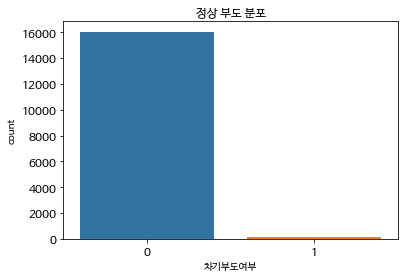

In [ ]:
plt.figure()
plt.title('정상 부도 분포')

sns.countplot(x='차기부도여부', data=df)

In [ ]:
col_list = df.columns[5:]

In [ ]:
for i in col_list :
  plt.figure()
  ax = sns.boxplot(x='차기부도여부', y=i, data=df)
  ax.set_title('산업대분류에 따른 ' + i + '분포')
  ax.set_ylim(-10,10)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# model_result_df = pd.DataFrame(columns={'데이터프레임', 'train_test_split(Y/R)', '변수선택법', '선택된 변수', 'sampling 방식' ,'적용모델', 'hyperparameter 변경','혼동행렬', 'Accuracy', 'Precision', 'Recall', 'F1-score'})
# model_result_df.to_csv('/content/drive/MyDrive/UBION_final_project/data/model_result_df.csv', index=False)

In [ ]:
model_result_df = pd.read_csv('/content/drive/MyDrive/UBION_final_project/data/model_result_df.csv')
model_result_df = model_result_df[['데이터프레임', 'train_test_split(Y/R)', '변수선택법', '선택된 변수', 'sampling 방식' ,'적용모델', 'hyperparameter 변경','혼동행렬', 'Accuracy', 'Precision', 'Recall', 'F1-score']]
model_result_df

,데이터프레임,train_test_split(Y/R),변수선택법,선택된 변수,sampling 방식,적용모델,hyperparameter 변경,혼동행렬,Accuracy,Precision,Recall,F1-score


In [ ]:
def store_model_result(CM, A, P, R, F):
  global model_result_df
  model_result_df['혼동행렬'] = CM
  model_result_df['Accuracy'] = A
  model_result_df['Precision'] = P
  model_result_df['Recall'] = R
  model_result_df['F1-score'] = F

In [ ]:
def show_result(y_test, prediction):

  # confusion_matrix 시각화
  sns.heatmap(confusion_matrix(y_test, prediction), annot=True,fmt="d", cmap='Reds')
  plt.xlabel('Predict')
  plt.ylabel('Actual')
  plt.show()

  #Confusion_matrix
  CM = confusion_matrix(y_test, prediction)
  print(CM)

  # 정확도
  A = round( accuracy_score(y_test,prediction),3)
  print("accuracy", A)

  #정밀도
  P = round( precision_score(y_test, prediction),3) 
  print("precision : ", P ) 

  #재현율
  R = round( recall_score(y_test, prediction), 3)
  print("recall : ", round( recall_score(y_test, prediction), 3) )

  #f1-score
  F = round( f1_score(y_test, prediction), 3)
  print("f1_score : ", F )
  
  store_model_result(CM, A, P, R, F)

In [ ]:
def change_cutoff(result_df):
  value_00 = result_df[(result_df['actual']==0) & (result_df['prediction']== 0)]['부도_prob'].max()
  value_01 = result_df[(result_df['actual']==0) & (result_df['prediction']== 1)]['부도_prob'].min()
  value_10 = result_df[(result_df['actual']==1) & (result_df['prediction']== 0)]['부도_prob'].max()
  value_11 = result_df[(result_df['actual']==1) & (result_df['prediction']== 1)]['부도_prob'].min()

  if value_10 < value_00:
    cutoff = value_11
    result_df.loc[(result_df['actual']==0) & (result_df['prediction']== 1) & (result_df['부도_prob']<cutoff) , 'prediction'] = 0
  
  if value_11 > value_01:
    cutoff= value_00
    result_df.loc[(result_df['actual']==1) & (result_df['prediction']== 0) & (result_df['부도_prob']>cutoff) , 'prediction'] = 1

  return result_df

In [ ]:
def Excute_svm(X_train, y_train, X_test, y_test):
  svc = SVC(random_state=0)

  svc.fit(X_train, y_train)
  prediction = svc.predict(X_test)

  show_result(y_test, prediction)

In [ ]:
def Excute_svm_change_cutoff(X_train, y_train, X_test, y_test):
  svc = SVC(random_state=0, probability=True)
  svc.fit(X_train, y_train)
  prediction = svc.predict(X_test)
  prediction_prob =svc.predict_proba(X_test)

  result_df = pd.DataFrame(prediction_prob, columns=['정상_prob','부도_prob'])
  result_df['actual'] = y_test
  result_df['prediction'] = prediction

  return_df = change_cutoff(result_df)
  show_result(result_df['actual'], result_df['prediction'])

In [ ]:
def Excute_pr(X_train, y_train, X_test, y_test):
  dt2 = DecisionTreeClassifier(max_depth=2)

  dt2.fit(X_train, y_train)
  prediction = dt2.predict(X_test)
  
  show_result(y_test, prediction)

In [ ]:
def Excute_pr_change_cutoff(X_train, y_train, X_test, y_test):
  dt2 = DecisionTreeClassifier(max_depth=2)
  dt2.fit(X_train, y_train)
  prediction = dt2.predict(X_test)
  prediction_prob =dt2.predict_proba(X_test)

  result_df = pd.DataFrame(prediction_prob, columns=['정상_prob','부도_prob'])
  result_df['actual'] = y_test
  result_df['prediction'] = prediction

  return_df = change_cutoff(result_df)
  show_result(result_df['actual'], result_df['prediction'])

In [ ]:
def RUSE(X_train, y_train):
  global model_result_df

  from imblearn.under_sampling import RandomUnderSampler
  rus = RandomUnderSampler()
  
  X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)
  model_result_df['sampling 방식'] = 'U'
  
  return X_undersampled, y_undersampled

In [ ]:
def ROSE(X_train, y_train):
  from imblearn.over_sampling import RandomOverSampler
  ros = RandomOverSampler()

  X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)
  model_result_df['sampling 방식'] = 'O'
  
  return X_oversampled, y_oversampled 

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/UBION_final_project/data/diff_train.csv')
test = pd.read_csv('/content/drive/MyDrive/UBION_final_project/data/diff_test.csv')

model_result_df['데이터프레임']= 'diff_df'
model_result_df['train_test_split(Y/R)']= 'Y'


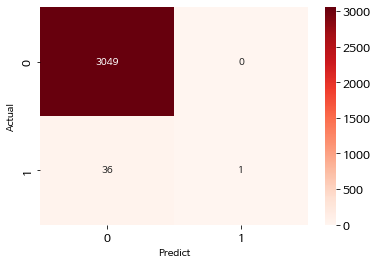

[[3049    0]
 [  36    1]]
accuracy 0.988
precision :  1.0
recall :  0.027
f1_score :  0.053


In [ ]:
Excute_svm_change_cutoff(X_undersampled, y_undersampled, X_test, y_test)

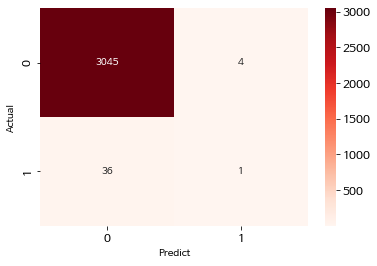

[[3045    4]
 [  36    1]]
accuracy 0.987
precision :  0.2
recall :  0.027
f1_score :  0.048


In [ ]:
Excute_svm_change_cutoff(X_oversampled, y_oversampled, X_test, y_test)

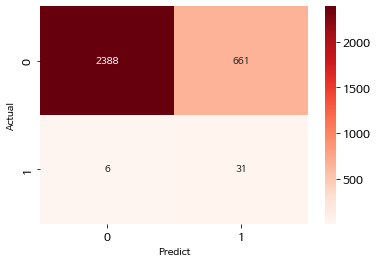

[[2388  661]
 [   6   31]]
accuracy 0.784
precision :  0.045
recall :  0.838
f1_score :  0.085


In [ ]:
Excute_pr_change_cutoff(X_undersampled, y_undersampled, X_test, y_test)

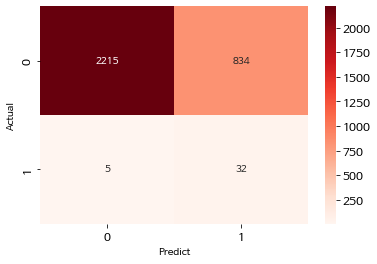

[[2215  834]
 [   5   32]]
accuracy 0.728
precision :  0.037
recall :  0.865
f1_score :  0.071


In [ ]:
Excute_pr_change_cutoff(X_oversampled, y_oversampled, X_test, y_test)

In [ ]:
데이터프레임 / train,test split (Y : 년도, R: random) /feature selection 방식 / selected variables / 가공형태/ model / hyperparameter 변경 값 / confusion matrix / Accuracy / Precision / Recall / F-1score 

SyntaxError: ignored

In [ ]:
model_result_df = pd.DataFrame(columns={'데이터프레임', 'train_test_split(Y/R)', '변수선택법', '선택된 변수', 'sampling 방식' ,'적용모델', 'hyperparameter 변경'})
def store_model_result(CM, A, P, R, F):
  global model_result_df
  model_result_df['혼동행렬'] = CM
  model_result_df['Accuracy'] = A
  model_result_df['Precision'] = P
  model_result_df['Recall'] = R
  model_result_df['F1-score'] = F

model_result_df['데이터프레임'] = df_name
model_result_df['train_test_split(Y/R)'] = train_test_split #Y : 연도별, R: 랜덤
model_result_df['변수선택법'] =  feature_selection_method #1,2,3,4,5
model_result_df['선택된 변수'] = selected_variables
model_result_df['sampling 방식'] = sampling # U(under), O(over), S(smote)
model_result_df['hyperparameter'] = hyperparameter

In [ ]:
df = pd.read_csv('v7_final.csv')

NameError: ignored